<a href="https://colab.research.google.com/github/LoznianuAnamaria/challenges/blob/main/Miami-Airport%20Pred/Aviation_Weather_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [40]:
!pip install metar
!pip install tensorflow

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from datetime import datetime, timedelta
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import LSTM, Dense
from urllib.request import urlopen

from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from google.colab import files
from metar import Metar
import seaborn as sns
import pandas as pd
import numpy as np
import re

# Load data

In [41]:
# Upload file from your local machine
uploaded = files.upload()
file_name = list(uploaded.keys())[0]  # Adjust the file name if necessary

# Load the data
raw_data = pd.read_csv(file_name)

Saving Aviation Weather Forecasting Using METAR Data Set.csv to Aviation Weather Forecasting Using METAR Data Set.csv


# Decode & Update METAR

In [42]:
def decode_metar(item):
  try:
    info = Metar.Metar(item['metar']) # Used https://github.com/python-metar/python-metar?tab=readme-ov-file for metar transformations
    processed_metar = {
        "code": info.code,
        "correction": info.correction,
        "station": info.station_id,
        "time": info.time,
        "date": item['date'],
        "wind_direction_degrees": info.wind_dir,
        "wind_speed_knots": info.wind_speed,
        "wind_gust_knots" : info.wind_gust,
        "wind_direction_from" : info.wind_dir_from,
        "wind_direction_to": info.wind_dir_to,
        "visibility_distance_miles": info.vis,
        "visibility_direction": info.vis_dir,
        "maximum_visibility": info.max_vis,
        "maximum_visibility_direction": info.max_vis_dir,
        "temperature_celsius": info.temp,
        "dew_point_celsius": info.dewpt,
        "pressure_inches": info.press,
        "runway": info.runway_visual_range() if info.runway else None,
        "weather": info.present_weather() if info.weather else None,
        "recent_weather": info.recent_weather() if info.recent else None,
        "sky_conditions": info.sky_conditions() if info.sky else None,
        "runways_windshear": info.windshear if len(info.windshear) > 1 else None,
        "direction_peak_wind_speed_last_1h": info.wind_dir_peak,
        "peak_wind_speed_last_1h": info.wind_speed_peak,
        "peak_wind_time": info.peak_wind_time,
        "wind_shift_time": info.wind_shift_time,
        "max_temp_last_6hr_celsius": info.max_temp_6hr,
        "min_temp_last_6hr_celsius": info.min_temp_6hr,
        "max_temp_last_24hr_celsius": info.max_temp_24hr,
        "min_temp_last_24hr_celsius": info.min_temp_24hr,
        "sea_level_pressure_millibars": info.press_sea_level,
        "precipitation_last_1hr_inches": info.precip_1hr,
        "precipitation_last_3h_inches": info.precip_3hr,
        "precipitation_last_6h_inches": info.precip_6hr,
        "precipitation_last_24h_inches": info.precip_24hr,
        "snowdepth_distance": info.snowdepth,
        "ice_accretion_last_1hr": info.ice_accretion_1hr,
        "ice_accretion_last_3hr": info.ice_accretion_3hr,
        "ice_accretion_last_6hr": info.ice_accretion_6hr
    }
    return processed_metar
  except Exception as e:
    print(f"Error parsing METAR: {e}")


def update_metar(metar, time=None, wind_direction_degrees=None, wind_speed_knots=None, wind_gust_knots=None,
                 visibility_distance_miles=None, temperature_celsius=None, dew_point_celsius=None,
                 pressure_inches=None, sky_conditions=None, sea_level_pressure_millibars=None,
                 max_temp_last_6hr_celsius=None, min_temp_last_6hr_celsius=None):

    # Time
    if time is not None:
        metar = re.sub(r'\d{6}Z', f'{time}', metar)

    # Wind
    if wind_direction_degrees is not None and wind_speed_knots is not None:
        wind_speed_knots_int = int(round(float(wind_speed_knots)))  # Ensure integer format
        wind_direction_degrees_str = f"{wind_direction_degrees:03}"  # Ensure 3 digits with leading zeros
        wind_part = f"{wind_direction_degrees_str}{wind_speed_knots_int:02}KT"  # Format wind correctly

        if wind_gust_knots is not None:
            wind_gust_knots_int = int(round(float(wind_gust_knots)))
            wind_part = f"{wind_direction_degrees_str}{wind_speed_knots_int:02}G{wind_gust_knots_int:02}KT"  # Correct gust formatting

        metar = re.sub(r'\d{5}(G\d{2,3})?KT', wind_part, metar)  # Ensure regex matches correctly


    # Visibility
    if visibility_distance_miles is not None:
        visibility_distance_miles_int = round(float(visibility_distance_miles))
        visibility_part = f"{visibility_distance_miles_int}SM"

        metar = re.sub(r'\d{1,2}(\.\d)?SM', visibility_part, metar)

    # Temperature and Dew Point
    if temperature_celsius is not None and dew_point_celsius is not None:
        temp_str = f"{temperature_celsius:+.1f}".replace('.0', '')  # Format and remove .0
        dew_point_str = f"{dew_point_celsius:+.1f}".replace('.0', '')  # Format and remove .0
        metar = re.sub(r'\+\d{2}(\.\d)?/\+\d{2}(\.\d)?', f'{temp_str}/{dew_point_str}', metar)

    # Pressure Inches
    if pressure_inches is not None:
        pressure_str = f'{int(float(pressure_inches)*100):04}'
        metar = re.sub(r'A\d{4}', f'A{pressure_str}', metar)

    # Sky Conditions
    if sky_conditions is not None:
        encoder = SkyEncoder()
        sky_code = encoder.get_sky_code(sky_conditions)

        # Remove old sky codes
        metar = re.sub(r'(\bFEW\b|\bSCT\b|\bBKN\b|\bOVC\b)\d{3}\S*', '', metar)

        # Find where to insert the new sky code (before "RMK" or at the end if "RMK" not present)
        rmk_index = metar.find(' RMK')
        if rmk_index != -1:
            # Insert the new sky code before RMK
            metar = metar[:rmk_index] + f' {sky_code}' + metar[rmk_index:]
        else:
            # Append the new sky code at the end if there's no RMK section
            metar += f' {sky_code}'

    # Sea Level Pressure
    if sea_level_pressure_millibars is not None:
        slp_str = f'{int(sea_level_pressure_millibars):04}'
        metar = re.sub(r'Q\d{4}', f'Q{slp_str}', metar)

       # Update 6-hour maximum and minimum temperatures
    if max_temp_last_6hr_celsius is not None:
        sign = '0' if max_temp_last_6hr_celsius >= 0 else '1'
        max_temp_str = f"1{sign}0{abs(int(max_temp_last_6hr_celsius)):02d}"
        # Remove any existing max temperature encoding and append the new one
        metar = re.sub(r' 1[01]0\d{2}', '', metar) + ' ' + max_temp_str

    if min_temp_last_6hr_celsius is not None:
        sign = '0' if min_temp_last_6hr_celsius >= 0 else '1'
        min_temp_str = f"2{sign}0{abs(int(min_temp_last_6hr_celsius)):02d}"
        # Remove any existing min temperature encoding and append the new one
        metar = re.sub(r' 2[01]0\d{2}', '', metar) + ' ' + min_temp_str

    return metar


# Data needed for later cells
class Airport:
    def __init__(self, name, code, distance_miles, location, metar=None):
        self.name = name
        self.code = code
        self.distance_miles = distance_miles # Distance from the miami international airport (KMIA)
        self.location = location # Orientation/location in report with the miami international airport (KMIA)
        self.metar = metar

    def __str__(self):
        return f"Name: {self.name}, Code: {self.code}, Distance: {self.distance_miles} miles, Location: {self.location}"


class WindDirectionConverter:
    """
    A class to handle the conversion of wind direction.
    """
    @staticmethod
    def extract_direction(text):
        match = re.search(r'^\S+', text)
        return match.group() if match else None

    @staticmethod
    def convert_direction(direction):
        direction_map = {
            "N": "S", "NE": "SW", "E": "W", "SE": "NW",
            "S": "N", "SW": "NE", "W": "E", "NW": "SE",
            "NNE": "SSW", "ENE": "WSW", "ESE": "WNW", "SSE": "NNW",
            "SSW": "NNE", "WSW": "ENE", "WNW": "ESE", "NNW": "SSE"
        }
        return direction_map.get(direction, "Unknown")

class SkyEncoder:
    def __init__(self):
        self.cloud_codes = {
            'FEW': '1/8 - 2/8',
            'SCT': '3/8 - 4/8',
            'BKN': '5/8 - 7/8',
            'OVC': '8/8',
            'NSC': 'No significant cloud',
            'SKC': 'Clear sky',
            'NCD': 'No clouds detected',
            'CLR': 'No cloud cover below 12,000 ft'
        }

    def get_sky_code(self, sky_conditions):
      """
      Generates a sky condition string from an array of tuples (cover, height, cloud).
      """
      sky_codes = []
      for cover, height, cloud in sky_conditions:
          height_str = f"{height:03}"  # Ensure height is formatted as three digits
          cloud_str = cloud if cloud else ""  # Include cloud type if specified
          sky_codes.append(f"{cover}{height_str}{cloud_str}")
      return ' '.join(sky_codes)


class AirportWeatherInfluence:
    """
    A class to determine if weather from a specific airport can influence Miami's weather.
    """
    influence_map = {
        "north": ["S", "SE", "SW"], "south": ["N", "NE", "NW"],
        "east": ["W", "SW", "NW"], "west": ["E", "SE", "NE"],
        "northeast": ["S", "SW", "W"], "northwest": ["S", "SE", "E"],
        "southeast": ["N", "NW", "W"], "southwest": ["N", "NE", "E"],
    }

    @classmethod
    def is_wind_blowing_towards_miami(cls, airport):
        if airport.metar is None:
            return False
        wind_direction_from = WindDirectionConverter.extract_direction(airport.metar.wind())
        wind_going_to = WindDirectionConverter.convert_direction(wind_direction_from)
        return wind_going_to in cls.influence_map.get(airport.location, [])

    @classmethod
    def get_closest_airport(cls, airports):
        if not airports:
            return None
        closest_airport = min(airports, key=lambda airport: airport.distance_miles)
        return closest_airport



In [43]:
raw_data.columns.tolist()

['airport_id', 'date', 'metar']

# Extract & decode input dataset
Convert meters from the [input dataset](https://market.oceanprotocol.com/asset/did:op:14312f0acb356539b95138f9e2cd54e9a00aa1f963d74e3e60268a089a196a5e) to human readable information

In [44]:
metars = []
raw_data.head()

for index, item in raw_data.iterrows():
  decoded_metar = decode_metar(item)

  if isinstance(decoded_metar, dict):
    metars.append(decoded_metar)

data = pd.DataFrame(metars)
# del raw_data # Cleanup RAM memory
data.to_csv('decoded_kmia_metars.csv', index=False)

Error parsing METAR: Unparsed groups in body '1822LVA1356 FF KZCRZQZX KZMAZQZX MKJKZPZX MKJKZQZX MPTOZQZX MPZLZQZX MUFHZQZX MUHAZPZX SPIMZQZA (ARR-ABX2260-KMIA-SPJC2200)' while processing 'SCGE 1822LVA1356 182200 FF KZCRZQZX KZMAZQZX MKJKZPZX MKJKZQZX MPTOZQZX MPZLZQZX MUFHZQZX MUHAZPZX 182200 SPIMZQZA (ARR-ABX2260-KMIA-SPJC2200)'
Error parsing METAR: Unparsed groups in body 'LVA0485 FF KFLLYFYX KMIAYFYX KZCRZQZX KZMAZQZX MHCCZQZX MKJKZQZX MMFRZQZX MPZLZQZX MUFHZQZX 251101 SEQMZPZX (FPL-AAL932-IS -B38M/M-SDE3GHIJ4RWXZ/B1L -SEQM1138 -N0462F340 PALAD1A PALAD UL318 VAMOS UL318 ESV DCT UGUPI UL7' while processing 'SPJR 251100Z VRB02KT CAVOK LVA0485 251101 FF KFLLYFYX KMIAYFYX KZCRZQZX KZMAZQZX MHCCZQZX MKJKZQZX MMFRZQZX MPZLZQZX MUFHZQZX 251101 SEQMZPZX (FPL-AAL932-IS -B38M/M-SDE3GHIJ4RWXZ/B1L -SEQM1138 -N0462F340 PALAD1A PALAD UL318 VAMOS UL318 ESV DCT UGUPI UL7'
Error parsing METAR: Unparsed groups in body '350/08KT' while processing 'KMIA 141853Z 350/08KT 10SM BKN035 19/12 A2997 RMK

In [45]:
data.columns.tolist()

['code',
 'correction',
 'station',
 'time',
 'date',
 'wind_direction_degrees',
 'wind_speed_knots',
 'wind_gust_knots',
 'wind_direction_from',
 'wind_direction_to',
 'visibility_distance_miles',
 'visibility_direction',
 'maximum_visibility',
 'maximum_visibility_direction',
 'temperature_celsius',
 'dew_point_celsius',
 'pressure_inches',
 'runway',
 'weather',
 'recent_weather',
 'sky_conditions',
 'runways_windshear',
 'direction_peak_wind_speed_last_1h',
 'peak_wind_speed_last_1h',
 'peak_wind_time',
 'wind_shift_time',
 'max_temp_last_6hr_celsius',
 'min_temp_last_6hr_celsius',
 'max_temp_last_24hr_celsius',
 'min_temp_last_24hr_celsius',
 'sea_level_pressure_millibars',
 'precipitation_last_1hr_inches',
 'precipitation_last_3h_inches',
 'precipitation_last_6h_inches',
 'precipitation_last_24h_inches',
 'snowdepth_distance',
 'ice_accretion_last_1hr',
 'ice_accretion_last_3hr',
 'ice_accretion_last_6hr']

# Data pre-process
Cleaning and preprocessing the data
1. Handling missing values
2. Encoding categorical data
3. Normalizing measurements
4. Convert columns data to numeric value

In [46]:
# ---------============= Dropping columns with excessive missing values =================---------
# Assessing the extent of missing data for each column
missing_data_summary = data.isnull().sum()

# Define a threshold for missing values (90%)
threshold_missing = 90

# Calculate the percentage of missing values for each column
missing_percentage = data.isnull().mean() * 100

# Identify columns to drop based on the threshold
columns_to_drop = missing_percentage[missing_percentage > threshold_missing].index.tolist()

# Dropping specified columns
data = data.drop(columns=columns_to_drop)


# ---------============= Convert columns data to numeric values =================---------
def transform_to_numeric(column_name, numeric_type, regex='(\d+)'):
  # Ensure the column is treated as a string
  data[column_name] = data[column_name].astype(str)

  # Revise the regex to be more inclusive or correct the pattern
  # Here we use \d+ to ensure we capture one or more digits, expecting at least one digit in the string
  extracted_data = data[column_name].str.extract(regex)

  # Convert the extracted strings to numeric, setting errors='coerce' to handle non-numeric cases
  data[column_name] = pd.to_numeric(extracted_data[0], errors='coerce')

  # Fill NaN values with a default value, e.g., 0, and convert to int
  data[column_name] = data[column_name].fillna(0).astype(numeric_type)

# Convert wind direction, gust and speed to numeric
transform_to_numeric('wind_direction_degrees', int)
transform_to_numeric('wind_gust_knots', int)
transform_to_numeric('wind_speed_knots', int)

# Convert temperature to numeric
transform_to_numeric('temperature_celsius', float)
transform_to_numeric('max_temp_last_6hr_celsius', float)
transform_to_numeric('min_temp_last_6hr_celsius', float)

# Convert dew_point to numeric
transform_to_numeric('dew_point_celsius', float)

# Convert visibility to numeric
transform_to_numeric('visibility_distance_miles', int)

# Convert pressure to numeric
transform_to_numeric('pressure_inches', float)

# Convert sea_level_pressure to numeric
transform_to_numeric('sea_level_pressure_millibars', int)

# Convert precipitation_last_1hr to numeric
transform_to_numeric('precipitation_last_1hr_inches', float, regex='(\d+\.?\d*)')

# Feature engineering
Extract additional useful information from the data (e.g., time-based features).

In [47]:
if 'time' in data.columns:
  # Convert 'time' column to datetime
  time = pd.to_datetime(data['time'])

  # Convert 'date' column to datetime
  date = pd.to_datetime(data['date'])

  # Extract date part from 'date' and time part from 'time'
  time_part = time.dt.time
  date_part = date.dt.date

  # Combine into a single datetime Series
  combined_datetime = pd.to_datetime(date_part.astype(str) + ' ' + time_part.astype(str))

  # Save it to the data frame
  data['date'] = combined_datetime

  data.drop(columns='time', inplace=True)

# Extract time-based features
data['hour'] = data['date'].dt.hour
data['day_of_week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

# Calculate rolling averages (7-day window for demonstration)
data['temp_7d_rolling_avg'] = data['temperature_celsius'].rolling(window=7*24, min_periods=1).mean()
data['wind_gust_7d_rolling_avg'] = data['wind_gust_knots'].rolling(window=7*24, min_periods=1).mean()

data.to_csv('processed_kmia_metars.csv', index=False)

# Remaining columns
data.columns.tolist()

['code',
 'station',
 'date',
 'wind_direction_degrees',
 'wind_speed_knots',
 'wind_gust_knots',
 'visibility_distance_miles',
 'temperature_celsius',
 'dew_point_celsius',
 'pressure_inches',
 'sky_conditions',
 'max_temp_last_6hr_celsius',
 'min_temp_last_6hr_celsius',
 'sea_level_pressure_millibars',
 'precipitation_last_1hr_inches',
 'hour',
 'day_of_week',
 'month',
 'year',
 'temp_7d_rolling_avg',
 'wind_gust_7d_rolling_avg']

In [48]:
data.head()

,code,station,date,wind_direction_degrees,wind_speed_knots,wind_gust_knots,visibility_distance_miles,temperature_celsius,dew_point_celsius,pressure_inches,...,max_temp_last_6hr_celsius,min_temp_last_6hr_celsius,sea_level_pressure_millibars,precipitation_last_1hr_inches,hour,day_of_week,month,year,temp_7d_rolling_avg,wind_gust_7d_rolling_avg
0,KMIA 010053Z 04009G15KT 10SM OVC025 23/18 A302...,KMIA,2014-01-01 00:53:00,40,9,15,10,23.0,18.0,30.0,...,0.0,0.0,1022,0.0,0,2,1,2014,23.000000,15.000000
1,KMIA 010153Z 04009G15KT 10SM OVC023 23/18 A302...,KMIA,2014-01-01 01:53:00,40,9,15,10,23.0,18.0,30.0,...,0.0,0.0,1023,0.0,1,2,1,2014,23.000000,15.000000
2,KMIA 010253Z 05009G19KT 10SM -RA OVC025 23/18 ...,KMIA,2014-01-01 02:53:00,50,9,19,10,22.0,17.0,30.0,...,0.0,0.0,1023,0.0,2,2,1,2014,22.666667,16.333333
3,KMIA 010353Z 07010KT 10SM OVC028 23/17 A3021 R...,KMIA,2014-01-01 03:53:00,70,10,0,10,23.0,17.0,30.0,...,0.0,0.0,1022,0.0,3,2,1,2014,22.750000,12.250000
4,KMIA 010453Z 07010KT 10SM OVC028 24/18 A3019 R...,KMIA,2014-01-01 04:53:00,70,10,0,10,23.0,17.0,30.0,...,0.0,0.0,1022,0.0,4,2,1,2014,22.800000,9.800000


# Visual representation

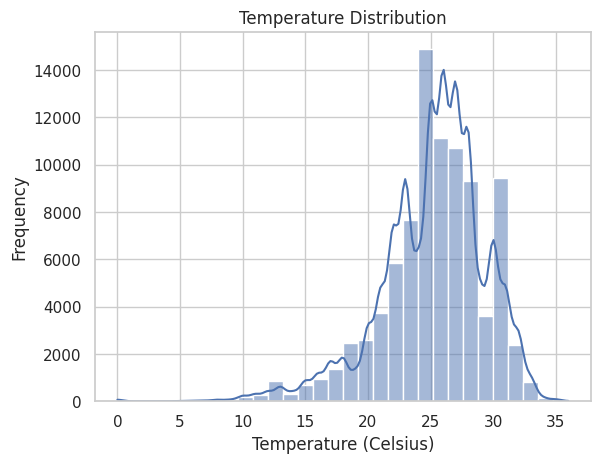

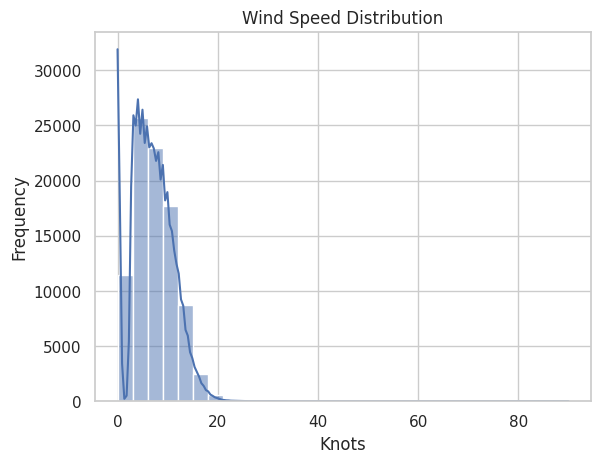

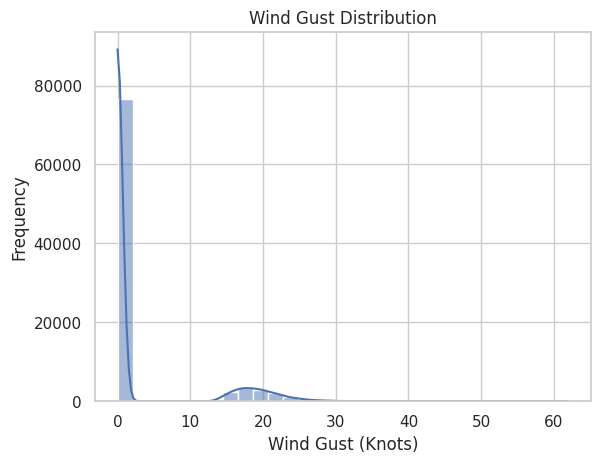

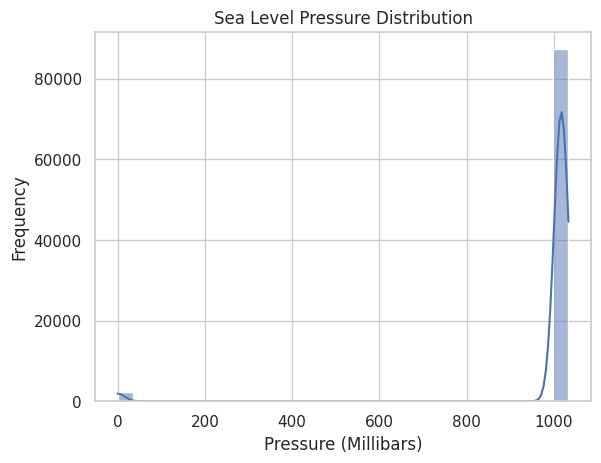

In [49]:
# Temperature distribution
sns.histplot(data['temperature_celsius'], bins=30, kde=True)
plt.title('Temperature Distribution')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Frequency')
plt.show()

# Wind speed distribution
sns.histplot(data['wind_speed_knots'], bins=30, kde=True)
plt.title('Wind Speed Distribution')
plt.xlabel('Knots')
plt.ylabel('Frequency')
plt.show()

# Wind Gust distribution
sns.histplot(data['wind_gust_knots'], bins=30, kde=True)
plt.title('Wind Gust Distribution')
plt.xlabel('Wind Gust (Knots)')
plt.ylabel('Frequency')
plt.show()

# Pressure distribution
sns.histplot(data['sea_level_pressure_millibars'], bins=30, kde=True)
plt.title('Sea Level Pressure Distribution')
plt.xlabel('Pressure (Millibars)')
plt.ylabel('Frequency')
plt.show()

# General Trends

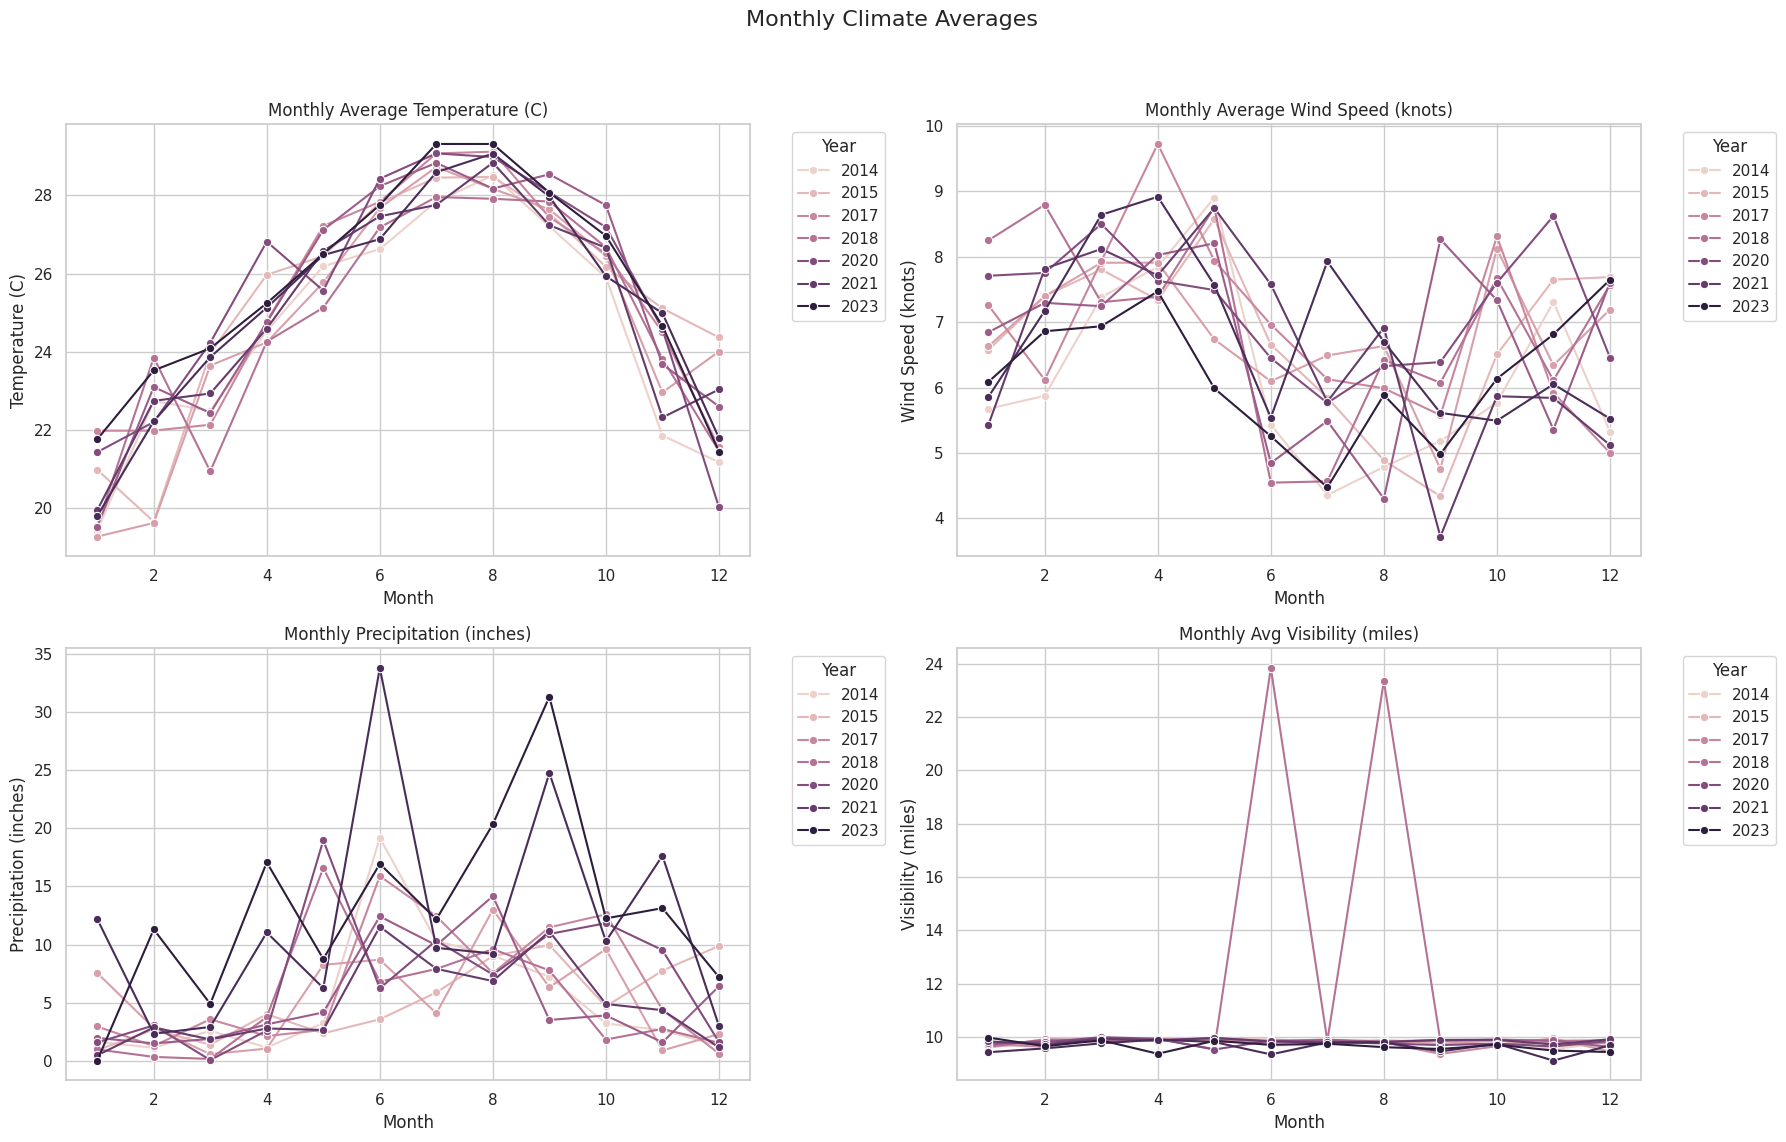

In [50]:
# Setting seaborn style
sns.set(style="whitegrid")

# Create subplots for each of the required plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Monthly Climate Averages', fontsize=16)

# Group by year and month to calculate monthly averages
monthly_avg = data.groupby(['year', 'month']).agg({
    'temperature_celsius': 'mean',  # Monthly Average Temperature
    'wind_speed_knots': 'mean',  # Monthly Average Wind Speed
    'precipitation_last_1hr_inches': 'sum',  # Monthly Precipitation (sum of all hourly measurements)
    'visibility_distance_miles': 'mean',  # Monthly Avg Visibility
}).reset_index()

# Plot for Monthly Average Temperature
sns.lineplot(ax=axes[0, 0], x="month", y="temperature_celsius", hue="year", data=monthly_avg, marker="o")
axes[0, 0].set_title("Monthly Average Temperature (C)")
axes[0, 0].set_xlabel("Month")
axes[0, 0].set_ylabel("Temperature (C)")
axes[0, 0].legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for Monthly Average Wind Speed
sns.lineplot(ax=axes[0, 1], x="month", y="wind_speed_knots", hue="year", data=monthly_avg, marker="o")
axes[0, 1].set_title("Monthly Average Wind Speed (knots)")
axes[0, 1].set_xlabel("Month")
axes[0, 1].set_ylabel("Wind Speed (knots)")
axes[0, 1].legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for Monthly Precipitation
sns.lineplot(ax=axes[1, 0], x="month", y="precipitation_last_1hr_inches", hue="year", data=monthly_avg, marker="o")
axes[1, 0].set_title("Monthly Precipitation (inches)")
axes[1, 0].set_xlabel("Month")
axes[1, 0].set_ylabel("Precipitation (inches)")
axes[1, 0].legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for Monthly Avg Visibility
sns.lineplot(ax=axes[1, 1], x="month", y="visibility_distance_miles", hue="year", data=monthly_avg, marker="o")
axes[1, 1].set_title("Monthly Avg Visibility (miles)")
axes[1, 1].set_xlabel("Month")
axes[1, 1].set_ylabel("Visibility (miles)")
axes[1, 1].legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show plot
plt.show()


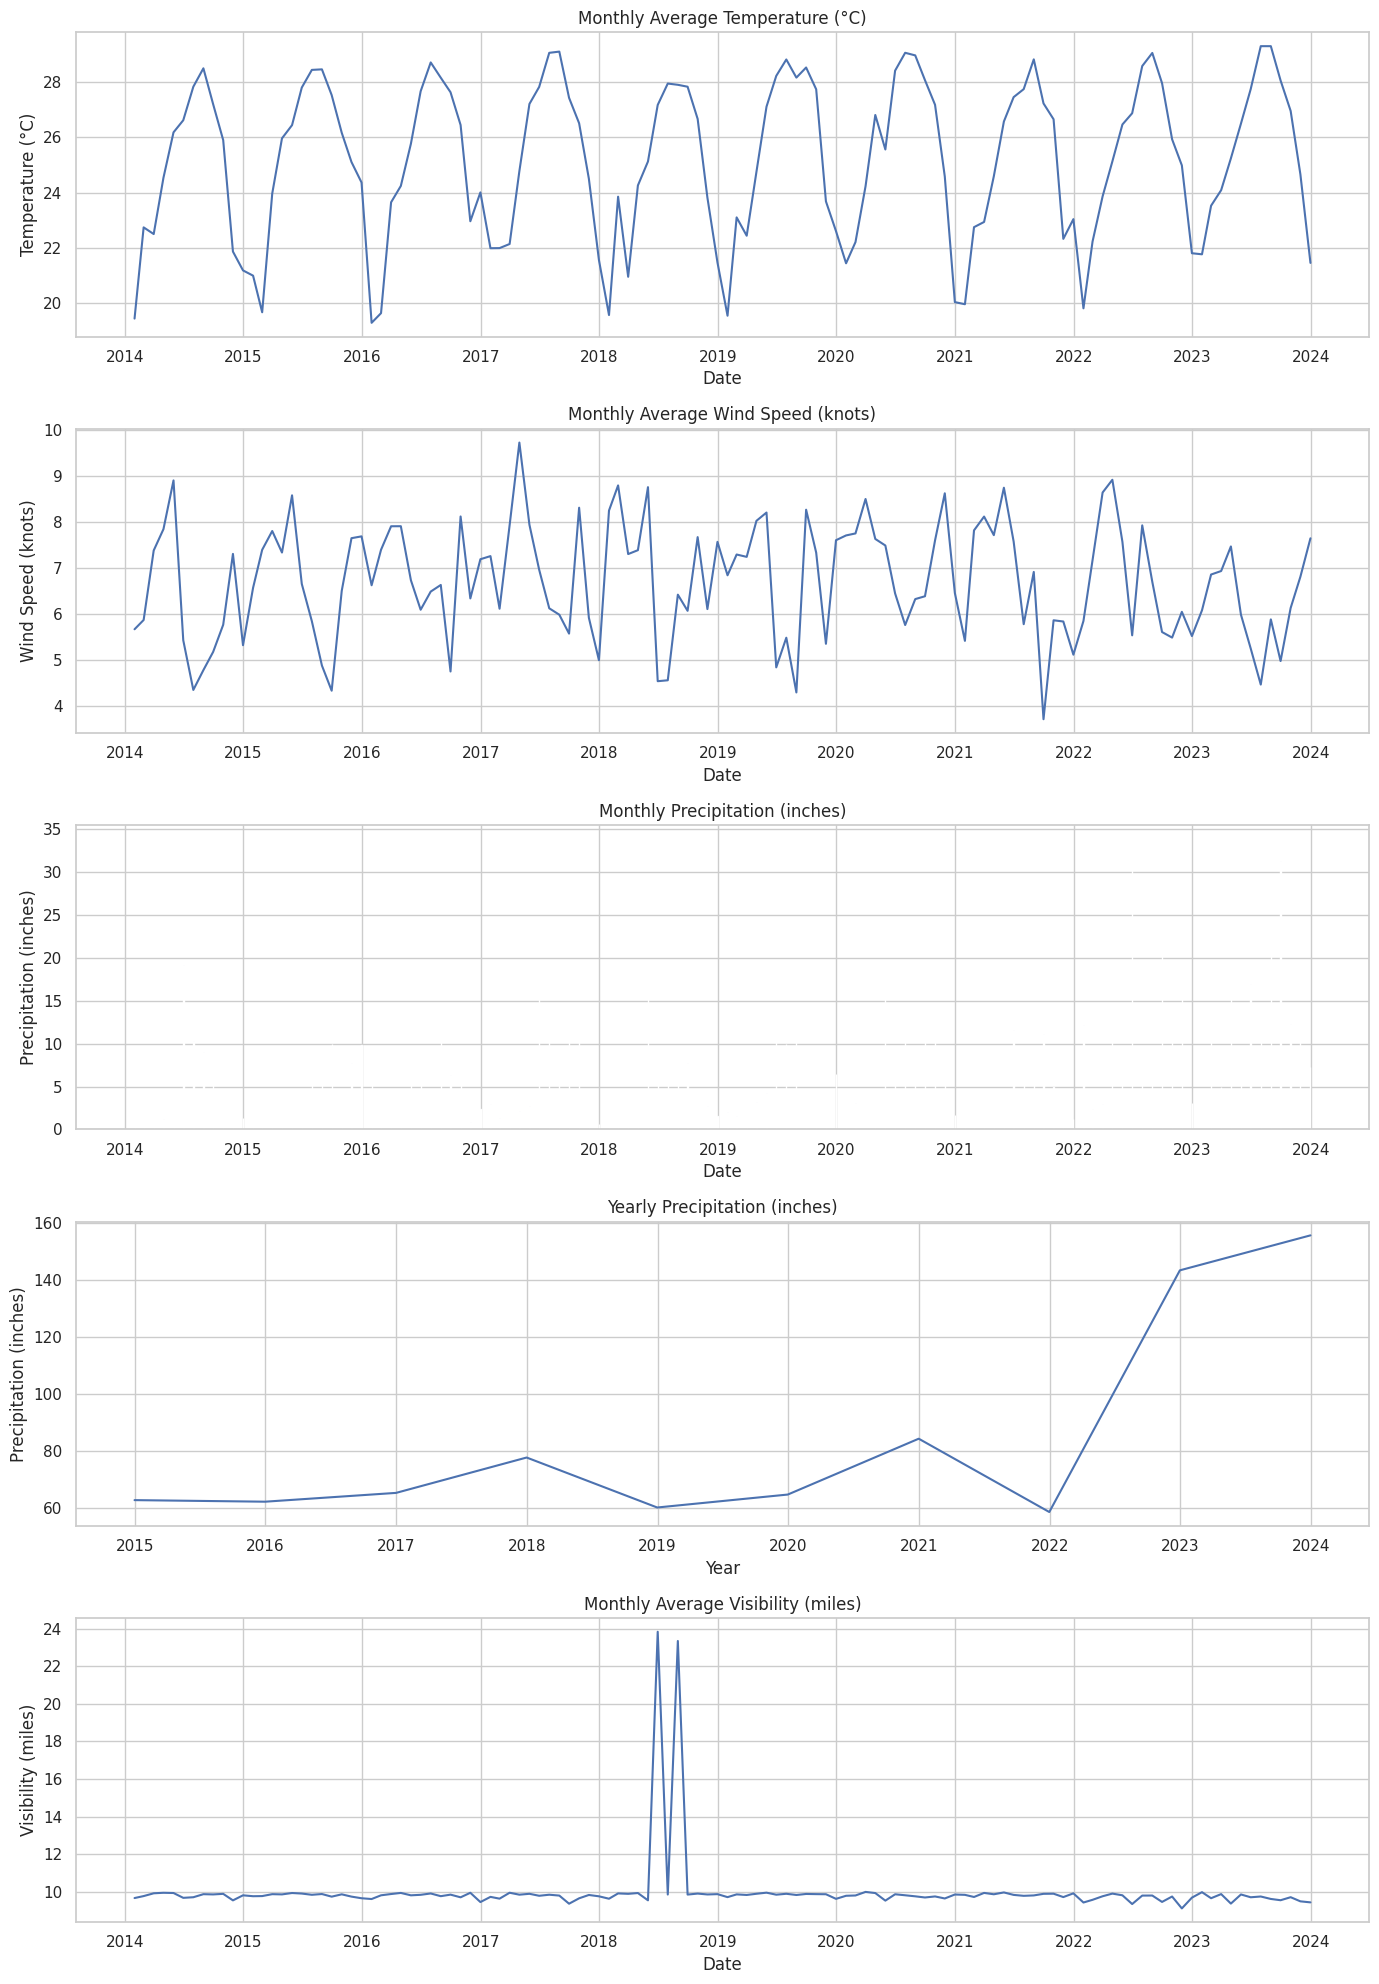

In [51]:
# Set 'date' as the index to facilitate time series analysis
if 'date' in data.columns: # Set the index to date only if it not already set
  data.set_index('date', inplace=True)

# 1. Average temperature for each month
monthly_avg_temp = data.resample('M').mean(numeric_only=True)['temperature_celsius']

# 2. Monthly average wind speed
monthly_wind_speed = data.resample('M').mean(numeric_only=True)['wind_speed_knots']

# 3. Seasonality in weather: we'll visualize this using temperature and precipitation
monthly_precipitation = data.resample('M').sum(numeric_only=True)['precipitation_last_1hr_inches']

# 4. Precipitation changes: Already calculated monthly sum, we'll also calculate yearly sum for a broader view
yearly_precipitation = data.resample('Y').sum(numeric_only=True)['precipitation_last_1hr_inches']

# 5. Monthly visibility
monthly_visibility = data.resample('M').mean(numeric_only=True)['visibility_distance_miles']

# Prepare data for plotting
trends_data = {
    'Monthly Avg Temperature (°C)': monthly_avg_temp,
    'Monthly Avg Wind Speed (knots)': monthly_wind_speed,
    'Monthly Precipitation (inches)': monthly_precipitation,
    'Yearly Precipitation (inches)': yearly_precipitation,
    'Monthly Avg Visibility (miles)': monthly_visibility
}

# Checking the prepared data for plotting
trends_data.keys()

# Creating a figure to hold our subplots
fig, axs = plt.subplots(5, 1, figsize=(14, 20))

# Plot for Monthly Average Temperature
axs[0].plot(trends_data['Monthly Avg Temperature (°C)'])
axs[0].set_title('Monthly Average Temperature (°C)')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Temperature (°C)')

# Plot for Monthly Average Wind Speed
axs[1].plot(trends_data['Monthly Avg Wind Speed (knots)'])
axs[1].set_title('Monthly Average Wind Speed (knots)')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Wind Speed (knots)')

# Plot for Monthly Precipitation
axs[2].bar(trends_data['Monthly Precipitation (inches)'].index, trends_data['Monthly Precipitation (inches)'].values)
axs[2].set_title('Monthly Precipitation (inches)')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Precipitation (inches)')

# Plot for Yearly Precipitation
axs[3].plot(trends_data['Yearly Precipitation (inches)'])
axs[3].set_title('Yearly Precipitation (inches)')
axs[3].set_xlabel('Year')
axs[3].set_ylabel('Precipitation (inches)')

# Plot for Monthly Average Visibility
axs[4].plot(trends_data['Monthly Avg Visibility (miles)'])
axs[4].set_title('Monthly Average Visibility (miles)')
axs[4].set_xlabel('Date')
axs[4].set_ylabel('Visibility (miles)')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plots
plt.show()

data.reset_index(inplace=True)

# Predictions

In [55]:
features = ['temperature_celsius',
            'visibility_distance_miles',
            'wind_direction_degrees',
            'dew_point_celsius',
            'wind_speed_knots',
            'wind_gust_knots',
            'pressure_inches',
            'hour',
            'day_of_week',
            'month',
            'sea_level_pressure_millibars',
            'temp_7d_rolling_avg',
            'wind_gust_7d_rolling_avg',
            'max_temp_last_6hr_celsius',
            'min_temp_last_6hr_celsius']
targets = ['temperature_celsius',
           'visibility_distance_miles',
           'dew_point_celsius',
           'wind_speed_knots',
           'wind_gust_knots',
           'pressure_inches',
           'sea_level_pressure_millibars',
           'max_temp_last_6hr_celsius',
           'min_temp_last_6hr_celsius']

last_row_value = data.iloc[-1]

print('Metar value: ', last_row_value['code'])


Metar value:  KMIA 312353Z 00000KT 10SM CLR 18/09 A3022 RMK AO2 SLP234 T01830094 10217 20183 53012


# Predict using MultiOutputRegressor
Predicting multiple variables like wind, visibility, weather conditions, clouds, temperature, air pressure, and trend simultaneously is a multi-output regression problem.

Note: We cannot use all the data to train the model as the RAM is limited on the collab environment

In [56]:
# Handling categorical variables (e.g., one-hot encoding for 'sky_conditions')
# data = pd.get_dummies(data, columns=['sky_conditions'])

# Collab doesn't support more data due to RAM limitations
selected_data = data.tail(10000)

X = selected_data[features]
y = selected_data[targets]

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBRegressor and MultiOutputRegressor
xgb_regressor = XGBRegressor(n_estimators=10, learning_rate=0.1, objective='reg:squarederror')
multioutput_regressor = MultiOutputRegressor(xgb_regressor)

# Train the MultiOutputRegressor
multioutput_regressor.fit(X_train, y_train)

# Predict with the trained MultiOutputRegressor
multi_output_regressor_prediction = multioutput_regressor.predict(X_test)[-1]

predicted_metar_regressor = update_metar(last_row_value['code'],
                                        temperature_celsius=multi_output_regressor_prediction[0],
                                        visibility_distance_miles=multi_output_regressor_prediction[1],
                                        dew_point_celsius=multi_output_regressor_prediction[2],
                                        wind_speed_knots=multi_output_regressor_prediction[3],
                                        wind_gust_knots=multi_output_regressor_prediction[4],
                                        pressure_inches=multi_output_regressor_prediction[5],
                                        sea_level_pressure_millibars=multi_output_regressor_prediction[6],
                                        max_temp_last_6hr_celsius = multi_output_regressor_prediction[7],
                                        min_temp_last_6hr_celsius = multi_output_regressor_prediction[8],
                                        sky_conditions=[])

print("=======-------- MultiOutputRegressor prediction =======--------")

print(f"""
Temperature (Celsius): {last_row_value['temperature_celsius']}, Predicted Temperature (Celsius): {multi_output_regressor_prediction[0]},
Visibility (miles): {last_row_value['visibility_distance_miles']}, Predicted Visibility (miles): {multi_output_regressor_prediction[1]},
Dew Point (Celsius): {last_row_value['dew_point_celsius']}, Predicted Dew Point (Celsius): {multi_output_regressor_prediction[2]},
Wind speed (knots): {last_row_value['wind_speed_knots']}, Predicted Wind Speed (knots): {multi_output_regressor_prediction[3]},
Wind Gusts (knots): {last_row_value['wind_gust_knots']}, Predicted Wind Gusts (knots): {multi_output_regressor_prediction[4]},
Pressure (inches): {last_row_value['pressure_inches']}, Predicted Pressure (inches): {multi_output_regressor_prediction[5]},
Sea Level Pressure (millibars): {last_row_value['sea_level_pressure_millibars']}, Predicted Sea Level Pressure (millibars): {multi_output_regressor_prediction[6]},
Max Temperature Last 6 Hours (Celsius): {last_row_value['max_temp_last_6hr_celsius']}, Predicted Max Temperature Last 6 Hours (Celsius): {multi_output_regressor_prediction[7]},
Min Temperature Last 6 Hours (Celsius): {last_row_value['min_temp_last_6hr_celsius']}, Predicted Min Temperature Last 6 Hours (Celsius): {multi_output_regressor_prediction[8]}
""")
print("Predicted metar using MultiOutputRegressor", predicted_metar_regressor)


=======-------- MultiOutputRegressor prediction =======--------

Temperature (Celsius): 18.0, Predicted Temperature (Celsius): 29.762693405151367,
Visibility (miles): 10, Predicted Visibility (miles): 9.87829303741455,
Dew Point (Celsius): 9.0, Predicted Dew Point (Celsius): 19.97425651550293,
Wind speed (knots): 0, Predicted Wind Speed (knots): 5.420334815979004,
Wind Gusts (knots): 0, Predicted Wind Gusts (knots): 1.0955545902252197,
Pressure (inches): 30.0, Predicted Pressure (inches): 29.192964553833008,
Sea Level Pressure (millibars): 1023, Predicted Sea Level Pressure (millibars): 976.6316528320312,
Max Temperature Last 6 Hours (Celsius): 21.0, Predicted Max Temperature Last 6 Hours (Celsius): 1.3785496950149536,
Min Temperature Last 6 Hours (Celsius): 18.0, Predicted Min Temperature Last 6 Hours (Celsius): 1.192979097366333

Predicted metar using MultiOutputRegressor KMIA 312353Z 00000KT 10SM CLR 18/09 A2919  RMK AO2 SLP234 T01830094 10217 20183 53012 10001 20001


# Predict using RandomForestRegressor

In [57]:
# Split the data into training and test sets
# Split the data, excluding the last row for training

X_train, X_last_row = data[features].iloc[:-1], data[features].iloc[-1:]
y_train = data[targets].iloc[:-1]

# Initialize and train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict the temperature for the last row
random_forest_prediction = model.predict(X_last_row)[0]

random_forest_predicted_metar = update_metar(last_row_value['code'],
                                        temperature_celsius=random_forest_prediction[0],
                                        visibility_distance_miles=random_forest_prediction[1],
                                        dew_point_celsius=random_forest_prediction[2],
                                        wind_speed_knots=random_forest_prediction[3],
                                        wind_gust_knots=random_forest_prediction[4],
                                        pressure_inches=random_forest_prediction[5],
                                        sea_level_pressure_millibars=random_forest_prediction[6],
                                        max_temp_last_6hr_celsius = random_forest_prediction[7],
                                        min_temp_last_6hr_celsius = random_forest_prediction[8],
                                        sky_conditions=[])

print("=======-------- RandomForestRegressor prediction =======--------")

print(f"""
Temperature (Celsius): {last_row_value['temperature_celsius']}, Predicted Temperature (Celsius): {random_forest_prediction[0]},
Visibility (miles): {last_row_value['visibility_distance_miles']}, Predicted Visibility (miles): {random_forest_prediction[1]},
Dew Point (Celsius): {last_row_value['dew_point_celsius']}, Predicted Dew Point (Celsius): {random_forest_prediction[2]},
Wind speed (knots): {last_row_value['wind_speed_knots']}, Predicted Wind Speed (knots): {random_forest_prediction[3]},
Wind Gusts (knots): {last_row_value['wind_gust_knots']}, Predicted Wind Gusts (knots): {random_forest_prediction[4]},
Pressure (inches): {last_row_value['pressure_inches']}, Predicted Pressure (inches): {random_forest_prediction[5]},
Sea Level Pressure (millibars): {last_row_value['sea_level_pressure_millibars']}, Predicted Sea Level Pressure (millibars): {random_forest_prediction[6]},
Max Temperature Last 6 Hours (Celsius): {last_row_value['max_temp_last_6hr_celsius']}, Predicted Max Temperature Last 6 Hours (Celsius): {random_forest_prediction[7]},
Min Temperature Last 6 Hours (Celsius): {last_row_value['min_temp_last_6hr_celsius']}, Predicted Min Temperature Last 6 Hours (Celsius): {random_forest_prediction[8]}
""")
print("Predicted metar using RandomForestRegressor", random_forest_predicted_metar)


=======-------- RandomForestRegressor prediction =======--------

Temperature (Celsius): 18.0, Predicted Temperature (Celsius): 17.81,
Visibility (miles): 10, Predicted Visibility (miles): 10.0,
Dew Point (Celsius): 9.0, Predicted Dew Point (Celsius): 9.67,
Wind speed (knots): 0, Predicted Wind Speed (knots): 0.65,
Wind Gusts (knots): 0, Predicted Wind Gusts (knots): 0.0,
Pressure (inches): 30.0, Predicted Pressure (inches): 30.0,
Sea Level Pressure (millibars): 1023, Predicted Sea Level Pressure (millibars): 1021.49,
Max Temperature Last 6 Hours (Celsius): 21.0, Predicted Max Temperature Last 6 Hours (Celsius): 21.06,
Min Temperature Last 6 Hours (Celsius): 18.0, Predicted Min Temperature Last 6 Hours (Celsius): 17.53

Predicted metar using RandomForestRegressor KMIA 312353Z 00000KT 10SM CLR 18/09 A3000  RMK AO2 SLP234 T01830094 10217 20183 53012 10021 20017


# Predict using LSTM

In [59]:
# Preprocess the data: Normalize features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[features])
scaled_targets = scaler.fit_transform(data[targets])

# Reshape data for LSTM: [samples, time steps, features]
# Here, we're simplifying by using the whole dataset as one sequence. In practice, you'd create multiple sequences.
X = np.array(scaled_features).reshape((scaled_features.shape[0], 1, scaled_features.shape[1]))
y = np.array(scaled_targets)

# Split the data, excluding the last sequence for training
X_train, X_last_seq = X[:-1], X[-1:]
y_train = y[:-1]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1]))  # Output layer with units for each target variable
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, verbose=1)

# Predict the last sequence
last_seq_prediction = model.predict(X_last_seq)

# Invert scaling to return to original scale of targets
lstm_prediction = scaler.inverse_transform(last_seq_prediction)[0]

lstm_predicted_metar = update_metar(last_row_value['code'],
                                        temperature_celsius=lstm_prediction[0],
                                        visibility_distance_miles=lstm_prediction[1],
                                        dew_point_celsius=lstm_prediction[2],
                                        wind_speed_knots=lstm_prediction[3],
                                        wind_gust_knots=lstm_prediction[4],
                                        pressure_inches=lstm_prediction[5],
                                        sea_level_pressure_millibars=lstm_prediction[6],
                                        max_temp_last_6hr_celsius = lstm_prediction[7],
                                        min_temp_last_6hr_celsius = lstm_prediction[8],
                                        sky_conditions=[])

print("=======-------- LSTM prediction =======--------")

print(f"""
Temperature (Celsius): {last_row_value['temperature_celsius']}, Predicted Temperature (Celsius): {lstm_prediction[0]},
Visibility (miles): {last_row_value['visibility_distance_miles']}, Predicted Visibility (miles): {lstm_prediction[1]},
Dew Point (Celsius): {last_row_value['dew_point_celsius']}, Predicted Dew Point (Celsius): {lstm_prediction[2]},
Wind speed (knots): {last_row_value['wind_speed_knots']}, Predicted Wind Speed (knots): {lstm_prediction[3]},
Wind Gusts (knots): {last_row_value['wind_gust_knots']}, Predicted Wind Gusts (knots): {lstm_prediction[4]},
Pressure (inches): {last_row_value['pressure_inches']}, Predicted Pressure (inches): {lstm_prediction[5]},
Sea Level Pressure (millibars): {last_row_value['sea_level_pressure_millibars']}, Predicted Sea Level Pressure (millibars): {lstm_prediction[6]},
Max Temperature Last 6 Hours (Celsius): {last_row_value['max_temp_last_6hr_celsius']}, Predicted Max Temperature Last 6 Hours (Celsius): {lstm_prediction[7]},
Min Temperature Last 6 Hours (Celsius): {last_row_value['min_temp_last_6hr_celsius']}, Predicted Min Temperature Last 6 Hours (Celsius): {lstm_prediction[8]}
""")
print("Predicted metar using LSTM", lstm_predicted_metar)

Epoch 1/10
2800/2800 [==============================] - 9s 3ms/step - loss: 0.0043
Epoch 2/10
2800/2800 [==============================] - 12s 4ms/step - loss: 2.5992e-05
Epoch 3/10
2800/2800 [==============================] - 8s 3ms/step - loss: 1.0715e-05
Epoch 4/10
2800/2800 [==============================] - 7s 3ms/step - loss: 5.3031e-06
Epoch 5/10
2800/2800 [==============================] - 8s 3ms/step - loss: 2.8054e-06
Epoch 6/10
2800/2800 [==============================] - 8s 3ms/step - loss: 1.8058e-06
Epoch 7/10
2800/2800 [==============================] - 7s 3ms/step - loss: 1.4998e-06
Epoch 8/10
2800/2800 [==============================] - 8s 3ms/step - loss: 1.2654e-06
Epoch 9/10
2800/2800 [==============================] - 14s 5ms/step - loss: 1.1533e-06
Epoch 10/10
1/1 [==============================] - 0s 187ms/step
=======-------- LSTM prediction =======--------

Temperature (Celsius): 18.0, Predicted Temperature (Celsius): 18.03445816040039,
Visibility (miles): 10, 

# Real time data


Preliminary Approach: Download the latest weather data for KMIA and surrounding airports to heuristically assess the impact of weather observed at various distances and directions relative to Miami Airport.

Resource used: http://tgftp.nws.noaa.gov/data/observations/metar/stations


Airports nearby:


1. **Opa-locka Executive Airport**
   - Code: KOPF
   - Distance: 11 miles
   - Location: North of Miami Airport

2. **Miami Executive Airport**
   - Code: KTMB
   - Distance: 13 miles
   - Location: Southwest of Miami Airport

3. **Fort Lauderdale-Hollywood International Airport**
   - Code: FLL (Note: The correct ICAO code is KFLL, not FFLL)
   - Distance: 21 miles
   - Location: North of Miami Airport

4. **Pompano Beach Airpark**
   - Code: KPMP
   - Distance: 36 miles
   - Location: North of Miami Airport

5. **Boca Raton Airport**
   - Code: KBCT
   - Distance: 45 miles
   - Location: North of Miami Airport

6. **Grand Bahama International Airport**
   - Code: MYGF
   - Distance: 72 miles
   - Location: Northwest of Miami Airport

7. **Key West International Airport**
   - Code: KEYW
   - Distance: 130 miles
   - Location: Southwest of Miami Airport

8. **Lynden Pindling International Airport (Nassau Airport)**
   - Code: MYNN
   - Distance: 186 miles
   - Location: Southwest of Miami Airport


In [70]:
def fetch_metar_report(station, debug=False):
    """
    Fetch and print METAR reports for given station codes.

    Args:
    - station: Station code (e.g., "KEWR")
    - debug: If True, print debug information (default: False)
    """
    base_url = "http://tgftp.nws.noaa.gov/data/observations/metar/stations"
    url = f"{base_url}/{station}.TXT"
    if debug:
        print(f"[ {url} ]", file=sys.stderr)
    try:
        urlh = urlopen(url)
        report = ""
        for line in urlh:
            if not isinstance(line, str):
                line = line.decode()  # convert bytes to string in Python 3
            if line.startswith(station):
                report = line.strip()

                try:
                  obs = Metar.Metar(line)

                  if debug:
                    print(obs.string())

                  return obs

                except Exception as e:
                  print(f"Error parsing METAR: {e}")

        if not report:
            print(f"No data for {station}\n\n")
    except Metar.ParserError as exc:
        print("METAR code: ", line)
        print(", ".join(exc.args), "\n")
    except Exception as e:
        print(f"Error retrieving {station} data: {e}\n")


# Create Airport objects
miami_airport = Airport("Miami International Airport", "KMIA", 0, "central")
opa_locka_airport = Airport("Opa-locka Executive Airport", "KOPF", 11, "north")
miami_executive_airport = Airport("Miami Executive Airport", "KTMB", 13, "southwest")
fort_lauderdale_airport = Airport("Fort Lauderdale-Hollywood International Airport", "FFLL", 21, "north")
pompano_beach_airpark = Airport("Pompano Beach Airpark", "KPMP", 36, "north")
boca_raton_airport = Airport("Boca Raton Airport", "KBCT", 45, "north")
grand_bahama_airport = Airport("Grand Bahama International Airport", "MYGF", 72, "northwest")
key_west_airport = Airport("Key West International Airport", "KEYW", 130, "southwest")
nassau_airport = Airport("Lynden Pindling International Airport", "MYNN", 186, "southwest")

# Create a list of Airport objects
airports = [
    fort_lauderdale_airport,
    miami_executive_airport,
    opa_locka_airport,
    pompano_beach_airpark,
    boca_raton_airport,
    key_west_airport,
    grand_bahama_airport,
    nassau_airport
]

miami_airport.metar = fetch_metar_report(miami_airport.code)
nearby_airports = []

for airport in airports:
  metar = fetch_metar_report(airport.code)

  if metar is not None:
    airport.metar = fetch_metar_report(airport.code)
    nearby_airports.append(airport)
    print(f"Name: {airport.name}, Code: {airport.code}, Distance: {airport.distance_miles} miles, Location relative to Miami: {airport.location}, Metar: {airport.metar.string()}", "\n\n")



Name: Fort Lauderdale-Hollywood International Airport, Code: FFLL, Distance: 21 miles, Location relative to Miami: north, Metar: station: FFLL
type: routine report, cycle 18 (automatic report)
time: Mon Feb 12 18:00:00 2024
temperature: 29.0 C
dew point: 24.0 C
wind: WSW at 6 knots
visibility: greater than 10000 meters
pressure: 1008.0 mb
sky: scattered clouds at 1500 feet
     a few cumulonimbus at 2700 feet
- CB-NE NOSIG
METAR: FFLL 121800Z 24006KT 9999 SCT015 FEW027CB 29/24 Q1008 RMK CB-NE NOSIG
 


Name: Miami Executive Airport, Code: KTMB, Distance: 13 miles, Location relative to Miami: southwest, Metar: station: KTMB
type: routine report, cycle 13 (automatic report)
time: Tue Feb 20 12:53:00 2024
temperature: 12.8 C
dew point: 10.6 C
wind: NNW at 6 knots
visibility: 10 miles
pressure: 1023.7 mb
sky: clear
sea-level pressure: 1023.6 mb
1-hour precipitation: 0.00in
remarks:
- Automated station (type 2)
- RAB40E49 $
METAR: KTMB 201253Z 34006KT 10SM CLR 13/11 A3023 RMK AO2 RAB40E49 S

# Real time prediction

Parameters and data

1. Wind Direction and Speed: We can assume that weather systems move in the direction of the wind. Therefore, airports with wind blowing towards Miami might have a more significant influence on its weather.
2. Precipitation and Weather Conditions: If most surrounding airports report rain or storms, it's reasonable to expect similar conditions might affect Miami, especially if those airports are upstream in terms of wind direction.
3. Temperature and Pressure Trends: Sudden changes in temperature or pressure at surrounding airports could indicate moving weather fronts.

In [65]:
class WeatherPredictor:
    def __init__(self, miami_airport, influencing_airports):
        self.miami_airport = miami_airport
        self.influencing_airports = influencing_airports

    def calculate_average(self, values):
        return int(sum(values) / len(values)) if values else 0

    def compare_and_adjust(self, current_value, average_value):
        if average_value > current_value:
            return "rising"
        elif average_value < current_value:
            return "falling"
        else:
            return "stable"

    def predict_weather(self, prediction_time):
        # Initialize variables to collect weather data
        weather_data = {
            'pressure': [],
            'wind_speed': [],
            'visibility': [],
            'wind_gust': [],
            'precipitation': [],
            'dew_point': [],
            'temperature': []
        }

        # Aggregate data from influencing airports
        for airport in self.influencing_airports:
            metar = airport.metar  # Assuming each airport object has a metar attribute
            weather_data['pressure'].append(metar.press.value())
            weather_data['wind_speed'].append(metar.wind_speed.value())
            weather_data['visibility'].append(metar.vis.value())

            if metar.wind_gust:
                weather_data['wind_gust'].append(metar.wind_gust.value())

            if metar.precip_1hr:
                weather_data['precipitation'].append(metar.precip_1hr.value())

            if metar.dewpt:
                weather_data['dew_point'].append(metar.dewpt.value())

            if metar.temp:
                weather_data['temperature'].append(metar.temp.value())

        # Calculate averages
        for key, values in weather_data.items():
            weather_data[key] = self.calculate_average(values)

        # Compare and adjust based on Miami's current weather
        miami_metar = self.miami_airport.metar

        metar_key_mapping = {
            'pressure': 'press',
            'wind_speed': 'wind_speed',
            'visibility': 'vis',
            'wind_gust': 'wind_gust',
            'precipitation': 'precip_1hr',
            'dew_point': 'dewpt',
            'temperature': 'temp'
        }

        for key, value in weather_data.items():
            metar_property = metar_key_mapping.get(key)

            if not metar_property:
                continue  # Skip if there's no corresponding metar property

            miami_value = getattr(miami_metar, metar_property)
            if miami_value is not None:
              trend = self.compare_and_adjust(miami_value.value(), value)
              print(f"The {key} is {trend} in Miami.")

        closest_influencing_airport = AirportWeatherInfluence.get_closest_airport(influencing_airports)

        # Return a new METAR code with predicted values
        return update_metar(
                  miami_metar.code,
                  time=prediction_time.strftime('%d%H%MZ'),
                  wind_speed_knots=weather_data['wind_speed'],
                  wind_gust_knots=weather_data['wind_gust'],
                  visibility_distance_miles=weather_data['visibility'],
                  temperature_celsius=weather_data['temperature'],
                  dew_point_celsius=weather_data['dew_point'],
                  pressure_inches=weather_data['pressure']
        )

influencing_airports = []
for airport in nearby_airports:
  if AirportWeatherInfluence.is_wind_blowing_towards_miami(airport):
    influencing_airports.append(airport)

prediction_time = datetime.now() + timedelta(hours=1)
predictor = WeatherPredictor(miami_airport, influencing_airports)

print("\n-----------========== Weather changes in Miami =============---------\n")
predicted_metar_code = predictor.predict_weather(prediction_time)

print("\n-----------========== Predicted Weather(", prediction_time, ") in Miami. =============---------\n")
print('Metar Code: ', predicted_metar_code)

print('Decoded', Metar.Metar(predicted_metar_code).string())


-----------========== Weather changes in Miami =============---------

The pressure is falling in Miami.
The wind_speed is falling in Miami.
The visibility is falling in Miami.
The dew_point is falling in Miami.
The temperature is falling in Miami.

-----------========== Predicted Weather( 2024-02-20 14:53:20.165819 ) in Miami. =============---------

Metar Code:  KMIA 201453Z 33006KT 0SM FEW030 14/09 A0000 RMK AO2 SLP235 T01390089 $

Decoded station: KMIA
type: routine report, cycle 15 (automatic report)
time: Tue Feb 20 14:53:00 2024
temperature: 13.9 C
dew point: 8.9 C
wind: NNW at 6 knots
visibility: 0 miles
pressure: 0.0 mb
sky: a few clouds at 3000 feet
sea-level pressure: 1023.5 mb
remarks:
- Automated station (type 2)
- $
METAR: KMIA 201453Z 33006KT 0SM FEW030 14/09 A0000 RMK AO2 SLP235 T01390089 $

